<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Granger Causality**

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
import scipy
from statsmodels.tsa.stattools import adfuller
from functools import reduce

from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Relevance**

In order to determine whether one time series causes another, the most common approach is the so-called **Granger causality test**.

The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another, first proposed in 1969. Ordinarily, regressions reflect "mere" correlations, but Clive Granger argued that causality in economics could be tested for by measuring the ability to predict the future values of a time series using prior values of another time series.

Granger defined the causality relationship based on two principles:

* The cause happens prior to its effect.
* The cause has unique information about the future values of its effect.


A time series X is said to **Granger-cause** Y if it can be shown, usually through a series of t-tests and F-tests on lagged values of X (and with lagged values of Y also included), that those X values provide statistically significant information about future values of Y.

If a time series is a **stationary process**, the test is performed using the level values of two (or more) variables. If the variables are non-stationary, then the test is done using first (or higher) differences. The number of lags to be included is usually chosen using an information criterion, such as the Akaike information criterion or the Schwarz information criterion. 

# **Import & Preprocessing**

**Import data**

In [0]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,266.301849,266.904572,264.159851,265.514771,265.514771,4518400
1,2010-02-02,266.481171,266.481171,262.819885,264.568329,264.568329,8223000
2,2010-02-03,263.347900,270.037842,263.128723,269.400208,269.400208,6020500
3,2010-02-04,267.497345,267.995483,261.798706,262.406433,262.406433,6780600
4,2010-02-05,263.213409,265.753876,260.254517,264.653015,264.653015,6335600


**Preprocess Original Series**

In [0]:
series = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
series = series.rename(columns={"Date": "date", "Close": "price"})
series = series.set_index('date')
series.head()

,price
date,
2010-02-01,265.514771
2010-02-02,264.568329
2010-02-03,269.400208
2010-02-04,262.406433
2010-02-05,264.653015


**Create Additional Series for Granger Causality Test**

(We are adding a series that is simply a copy of the original series but shifted by t-1. This is a 'ideal case' since in financial time series the previous time step determines to a strong degree the next one.)

In [0]:
series = series.rename(columns={"price": "present"})
series['past'] = ((series.present).shift(1))
series = series.dropna()
series.head()

,present,past
date,,
2010-02-02,264.568329,265.514771
2010-02-03,269.400208,264.568329
2010-02-04,262.406433,269.400208
2010-02-05,264.653015,262.406433
2010-02-08,265.738953,264.653015


**Difference both Series for Stationarity in Granger Causality Test**

(Granger causality requires stationary time series as input)

In [0]:
differenced = series
differenced = differenced.drop(columns=['present', 'past'])
differenced['present'] = ((series.present) - ((series.present).shift(1)))
differenced['past'] = ((series.past) - ((series.past).shift(1)))
differenced = differenced.dropna()
differenced.head()

,present,past
date,,
2010-02-03,4.831879,-0.946442
2010-02-04,-6.993775,4.831879
2010-02-05,2.246582,-6.993775
2010-02-08,1.085938,2.246582
2010-02-09,1.479461,1.085938


# **Exploratory Data Analysis**

## **Analyse Univariate Series**

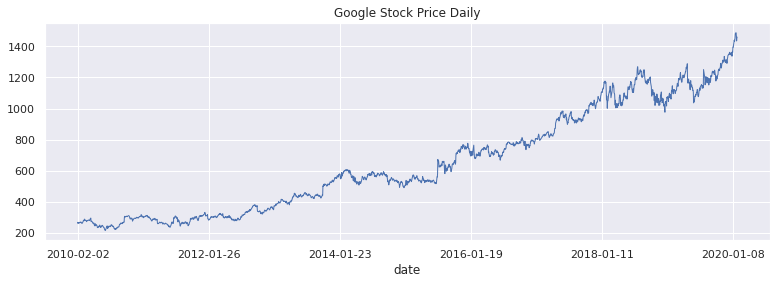

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
series.present.plot(linewidth=1.0,title='Google Stock Price Daily')

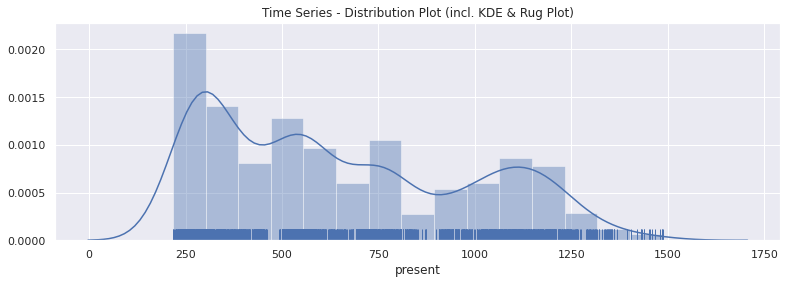

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((series.present), hist=True, rug=True).set_title('Time Series - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

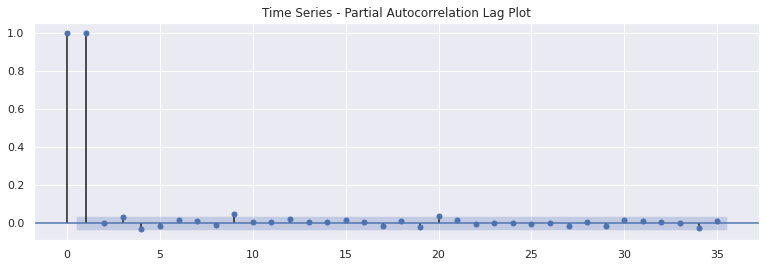

In [0]:
plot_pacf(series.present)
plt.title('Time Series - Partial Autocorrelation Lag Plot')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


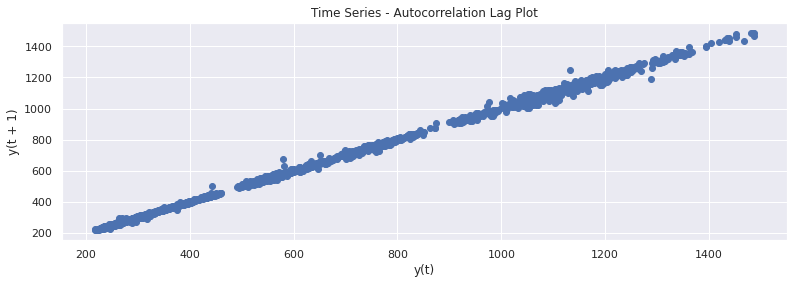

In [0]:
lag_plot(series)
plt.title('Time Series - Autocorrelation Lag Plot')
plt.show()

## **Analyse Bivariate Series**

To test a very clear causal relationship, let's add a lag t-1 to the financial time series and test them for Granger causality. Since there is a clear autocorrelation in t-1 as outlined above, the Granger causality test should be positive (meaning to reject H0 of Granger causality test).

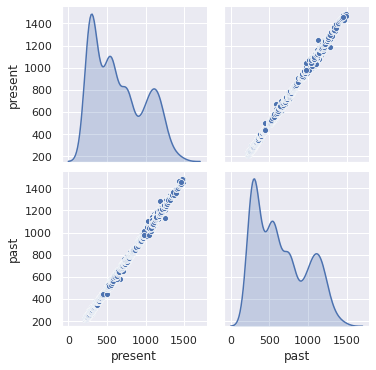

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.pairplot(series, diag_kind='kde')

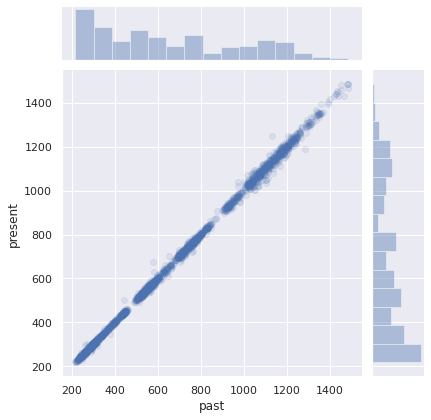

In [0]:
sns.jointplot(x="past", y="present", data=series, alpha=0.1);

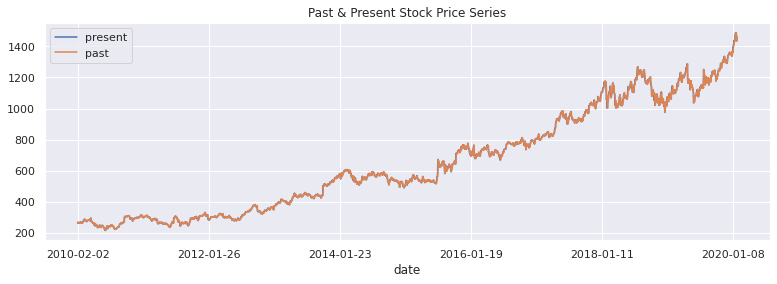

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
series.plot(linewidth=1.5,title='Past & Present Stock Price Series')

# **Stationarity Test**

Granger causality (1969) requires both series to be stationary, so let's test whether this is true for both time series, and difference them until they are stationary.

## **Stationarity Test (Past)**

In [0]:
# Augmented Dicker Fuller test. H0: There is a unit root for the series (non stationary)
statsmodels.tsa.stattools.adfuller(series.past, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(2.9180072584443,
 0.9997040665808604,
 20,
 2494,
 {'1%': -2.566637054647272,
  '10%': -1.616713939107425,
  '5%': -1.941108237457268},
 18859.505835476455)

p-value above 0.05. Not reject H0. Series is not stationary Transformation for Granger test required (difference time series).

In [0]:
statsmodels.tsa.stattools.adfuller(differenced.past, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.300247000508126,
 1.7331869542573804e-20,
 17,
 2496,
 {'1%': -2.5666363353866184,
  '10%': -1.616714023745387,
  '5%': -1.9411081502986165},
 18859.171083336038)

Past series is now stationary. They have been a unit root before, since it had to be differenced once only.

## **Stationarity Test (Present)**

In [0]:
statsmodels.tsa.stattools.adfuller(series.present, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(2.9203780191829734,
 0.9997075998411147,
 20,
 2494,
 {'1%': -2.566637054647272,
  '10%': -1.616713939107425,
  '5%': -1.941108237457268},
 18859.519137810224)

p-value above 0.05. Not reject H0. Series is not stationary Transformation for Granger test required (difference time series).

In [0]:
statsmodels.tsa.stattools.adfuller(differenced.present, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.307906843205679,
 1.672093316997256e-20,
 17,
 2496,
 {'1%': -2.5666363353866184,
  '10%': -1.616714023745387,
  '5%': -1.9411081502986165},
 18858.655293548058)

Past series is now stationary. They have been a unit root before, since it had to be differenced once only.

## **Visualized Differenced Series**

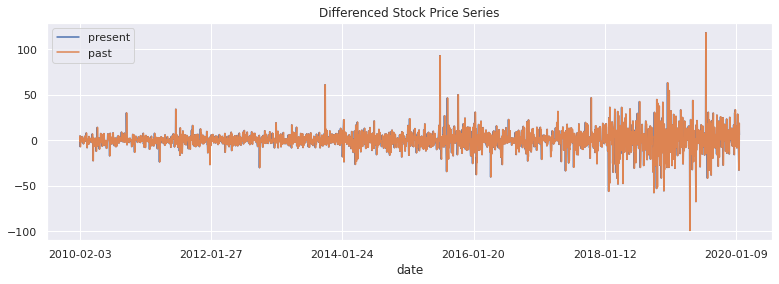

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
differenced.plot(linewidth=1.5,title='Differenced Stock Price Series')

# **Causality Test**

## **Johansen Cointegration**

* H0 is no cointegration. 
* If two time series, X and Y, are cointegrated, there must exist Granger causality either from X to Y, or from Y to X, both in both directions.
* However the presence of Granger causality in either or both directions between X and Y does not necessarily imply that the series will be cointegrated.

In [0]:
statsmodels.tsa.stattools.coint(differenced.past, differenced.present, trend='ct', method='aeg', autolag='aic')

(-11.75165534475663,
 2.218000390174392e-21,
 array([-4.33376918, -3.78435647, -3.49912914]))

Very small p-value. Reject H0. Cointegration present. Granger causality must exit.

## **Granger Causality Test**

* Granger causality require stationary data and data in same scale (or normalized) (Granger causality (1969) requires both series to be stationary. Toda-Yamamoto causality requies no such criteria, the test can be applied to both stationary and non stationary data.)
* Granger causality cannot take into account third hidden factors affecting both series
* Granger can also not differentiate no-linear relationships

In [0]:
# Granger Causality
# Null hypothesis: x2 does NOT Granger cause x1
# Reject null hypothesis if the p-values are below 0.05
statsmodels.tsa.stattools.grangercausalitytests(differenced, maxlag = 5, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0317 , p=0.0016  , df_denom=2510, df_num=1
ssr based chi2 test:   chi2=10.0437 , p=0.0015  , df=1
likelihood ratio test: chi2=10.0237 , p=0.0015  , df=1
parameter F test:         F=10.0317 , p=0.0016  , df_denom=2510, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0545  , p=0.9470  , df_denom=2508, df_num=2
ssr based chi2 test:   chi2=0.1092  , p=0.9469  , df=2
likelihood ratio test: chi2=0.1092  , p=0.9469  , df=2
parameter F test:         F=5.0736  , p=0.0063  , df_denom=2508, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2962  , p=0.8282  , df_denom=2506, df_num=3
ssr based chi2 test:   chi2=0.8903  , p=0.8278  , df=3
likelihood ratio test: chi2=0.8901  , p=0.8278  , df=3
parameter F test:         F=3.6805  , p=0.0116  , df_denom=2506, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2464  , p=0.

{1: ({'lrtest': (10.02371195465821, 0.0015453770816024357, 1),
   'params_ftest': (10.031739441060889, 0.0015571347095958146, 2510.0, 1.0),
   'ssr_chi2test': (10.043729567882718, 0.0015286739153979258, 1),
   'ssr_ftest': (10.031739441060733, 0.0015571347095958146, 2510.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (0.10915119921628502, 0.9468869218716363, 2),
   'params_ftest': (5.073609912396231, 0.006324187253664515, 2508.0, 2.0),
   'ssr_chi2test': (0.10915357066423403, 0.9468857991257775, 2),
   'ssr_ftest': (0.05448987962298944, 0.946969213539215, 2508.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (0.8901188215459115, 0.8278116866917393, 3),
   'params_ftest': (3.680520708802451, 0.011620868082954207, 2506.0, 3.0),
   'ssr_chi2test': (0.8902766083072072, 0.8277736309766134, 3),
   'ssr_ftest': (0.29616795173474864, 0.8281964103986258, 2506.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
 

Excellent result: p-value for first lag at almost zero. Reject H0. It can be rejected that x2 (past values) does not Granger cause x1 (present values of same time series). Or in layman's terms: there is a strong indication that past price value cause the present price values.

It also makes sense that all other p-values are large and hence there is no more causality, since stock market prices are typical similar to random walks with drift, where the current price is mostly determined by the previous price step, but not further in the past (Markov chain).